<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E5%8F%B0%E5%8C%96%E4%BA%8C%E9%83%A8_%E5%A6%82%E4%BD%95%E6%8F%90%E5%8D%87%E8%BD%89%E6%8F%9B%E7%8E%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score,mean_absolute_error
import xgboost
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier,XGBRegressor
from sklearn.svm import SVR
import lightgbm
from sklearn.metrics import f1_score,classification_report
import warnings;warnings.simplefilter('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
data = pd.read_excel('/content/drive/My Drive/台化二部/台化二部實驗數據_new/複本 操作與品管數據(20190723提供).xlsx')
data.head()

,Unnamed: 0,R141入口,Unnamed: 2,Unnamed: 3,Unnamed: 4,R141反應溫度,Unnamed: 6,Unnamed: 7,Unnamed: 8,R141入口.1,Unnamed: 10,品管數據,Unnamed: 12
0,NaN,新鮮苯流量(M3/h),DIPB流量(M3/h),溫度(℃),壓力(KGf/cm2 G),第一床(℃),第二床(℃),第三床(℃),第四床(℃),溫度(℃),壓力(KGf/cm2 G),ppm,%
1,DATE,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率
2,2013-08-20 10:10:00,31.212,24.9928,169.894,NaN,167.057,166.569,166.279,165.041,NaN,12.297,NaN,NaN
3,2013-08-20 10:20:00,31.2236,25.0668,169.753,NaN,167.051,166.576,166.26,164.97,NaN,12.2914,NaN,NaN
4,2013-08-20 10:30:00,31.5726,25.163,169.526,NaN,167.042,166.584,166.235,164.877,NaN,12.3175,NaN,NaN


In [0]:
中文map = {
    'PHL-DCS-FIC1147_PV':'R141入口_新鮮苯流量(M3/h)',
    'PHL-DCS-FIC1149A_PV':'R141入口_DIPB流量(M3/h)',
    'PHL-DCS-TIC1163_PV':'R141入口_溫度(℃)',
    'PHL-DCS-PI1162_PV':'R141入口_壓力(KGf/cm2 G)',
    'PHL-DCS-TI1166_PV':'R141反應溫度_第一床(℃)',
    'PHL-DCS-TI1167_PV':'R141反應溫度_第二床(℃)',
    'PHL-DCS-TI1168_PV':'R141反應溫度_第三床(℃)',
    'PHL-DCS-TI1169_PV':'R141反應溫度_第四床(℃)',
    'PHL-DCS-TI1170_PV':'R141入口.1_溫度(℃)',
    'PHL-DCS-PIC1166_PV':'R141入口.1_壓力(KGf/cm2 G)',
    'T121 EB含量':'T121 EB含量',
    'DIPB轉化率':'DIPB轉化率',   
}

# 轉換成表格數據

In [0]:
def clean(data):
  data = data.dropna(how='all')
  columns = data.iloc[1,:]
  data = data.iloc[2:,:]
  data.columns = columns
  data = data.set_index('DATE')
  data.columns.name = None
  for col in data.columns:
    data[col] = pd.to_numeric(data[col],errors='coerce')
  return data

In [138]:
data = clean(data)
data.head()

,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率
DATE,,,,,,,,,,,,
2013-08-20 10:10:00,31.212050,24.992781,169.893986,NaN,167.057086,166.569303,166.278953,165.041317,NaN,12.297010,NaN,NaN
2013-08-20 10:20:00,31.223557,25.066836,169.752653,NaN,167.050706,166.575684,166.259814,164.969540,NaN,12.291411,NaN,NaN
2013-08-20 10:30:00,31.572592,25.163049,169.525828,NaN,167.042458,166.583934,166.235069,164.876743,NaN,12.317545,NaN,NaN
2013-08-20 10:40:00,31.886214,25.136713,169.316875,NaN,167.034209,166.592183,166.210325,164.783946,NaN,12.317918,NaN,NaN
2013-08-20 10:50:00,31.855439,25.220729,169.665105,NaN,167.025961,166.600433,166.185580,164.691149,NaN,12.315540,NaN,NaN


In [0]:
features = data.drop(['DIPB轉化率'],axis=1).columns.tolist()
y_name = 'DIPB轉化率'

# 缺失

In [140]:
miss = pd.DataFrame(data.isnull().sum(),columns=['miss total'])
miss['miss total%'] = round(miss['miss total']/len(data),3)
miss.style.background_gradient()

,miss total,miss total%
PHL-DCS-FIC1147_PV,71,0.001
PHL-DCS-FIC1149A_PV,71,0.001
PHL-DCS-TIC1163_PV,71,0.001
PHL-DCS-PI1162_PV,47277,0.569
PHL-DCS-TI1166_PV,71,0.001
PHL-DCS-TI1167_PV,71,0.001
PHL-DCS-TI1168_PV,71,0.001
PHL-DCS-TI1169_PV,71,0.001
PHL-DCS-TI1170_PV,47276,0.569
PHL-DCS-PIC1166_PV,71,0.001


# 取樣時間

In [0]:
from collections import Counter

def get_time_step(col): 
  time = data[~data[col].isnull()].index
  delta = time[1:] - time[:-1]
  return Counter(delta).most_common(1)

In [142]:
for i in data.columns:
  print(i,get_time_step(i))

PHL-DCS-FIC1147_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-FIC1149A_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-TIC1163_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-PI1162_PV [(Timedelta('0 days 00:10:00'), 35749)]
PHL-DCS-TI1166_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-TI1167_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-TI1168_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-TI1169_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-TI1170_PV [(Timedelta('0 days 00:10:00'), 35750)]
PHL-DCS-PIC1166_PV [(Timedelta('0 days 00:10:00'), 82953)]
T121 EB含量 [(Timedelta('0 days 08:00:00'), 1505)]
DIPB轉化率 [(Timedelta('1 days 00:00:00'), 478)]


# 統計資訊

In [143]:
data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
PHL-DCS-FIC1147_PV,82957,33.274,11.0211,0.0305995,31.1159,35.1648,40.9854,52.7277
PHL-DCS-FIC1149A_PV,82957,22.7352,6.74096,0,24.1729,24.8027,25.4955,29.7189
PHL-DCS-TIC1163_PV,82957,165.898,16.8214,110.036,168.804,170.478,173.021,184.354
PHL-DCS-PI1162_PV,35751,14.4079,0.130853,7.40588,14.3798,14.4238,14.4401,15.1049
PHL-DCS-TI1166_PV,82957,157.729,36.0506,17.4919,165.681,167.544,170.294,182.3
PHL-DCS-TI1167_PV,82957,157.846,36.1358,17.2973,165.378,167.692,170.671,177.282
PHL-DCS-TI1168_PV,82957,157.635,36.0933,17.1474,165.01,167.44,170.388,187.304
PHL-DCS-TI1169_PV,82957,156.099,36.585,0,163.469,166.494,169.366,176.017
PHL-DCS-TI1170_PV,35752,164.57,6.07906,54.7927,164.389,165.373,166.366,173.644
PHL-DCS-PIC1166_PV,82957,11.3938,3.14274,0,12.2974,12.2997,12.3019,12.7299




# > 刪去異常樣本



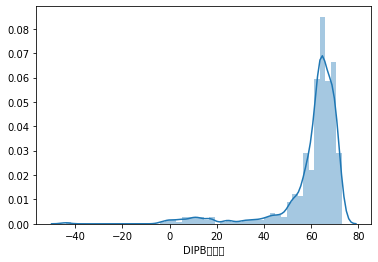

In [144]:
sns.distplot(data['DIPB轉化率'].dropna())

In [0]:
scaler = StandardScaler()
data[:] = scaler.fit_transform(data[:])

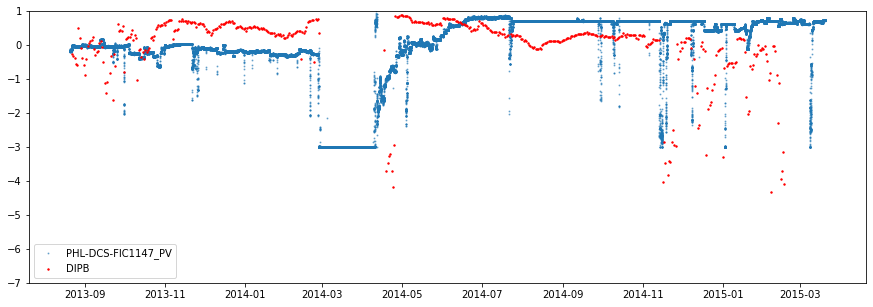

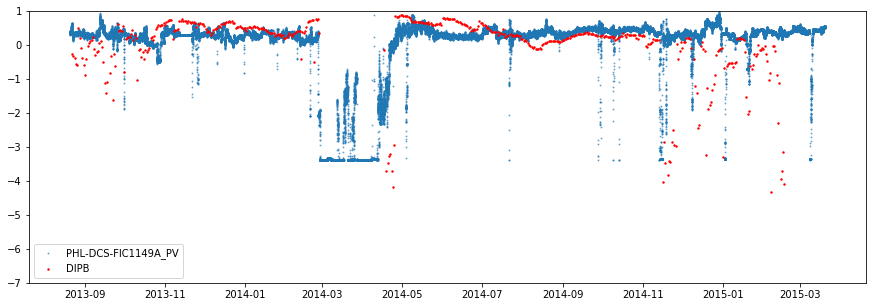

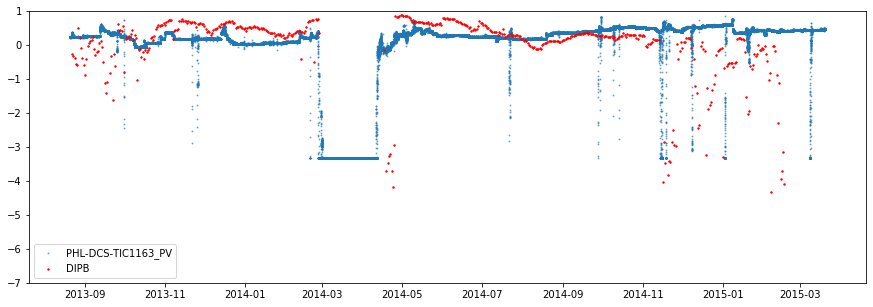

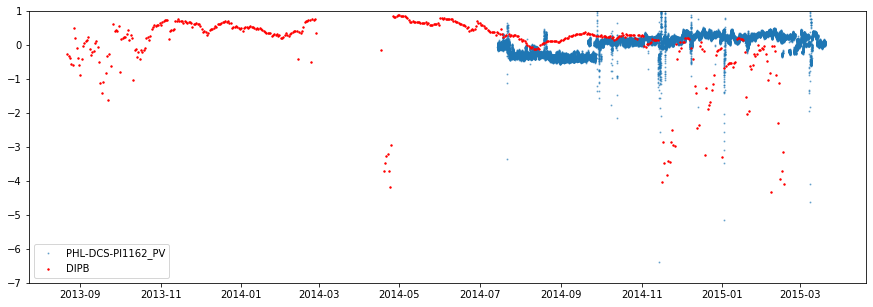

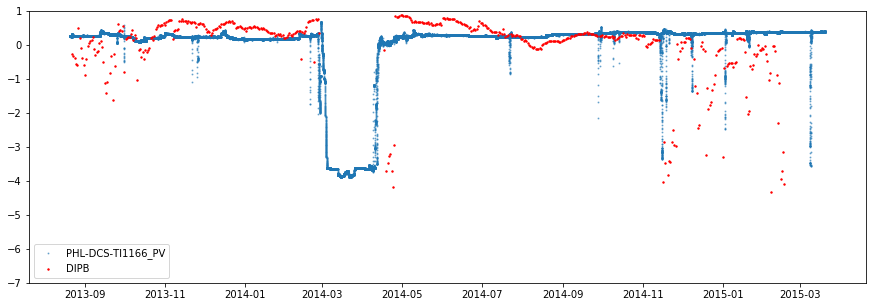

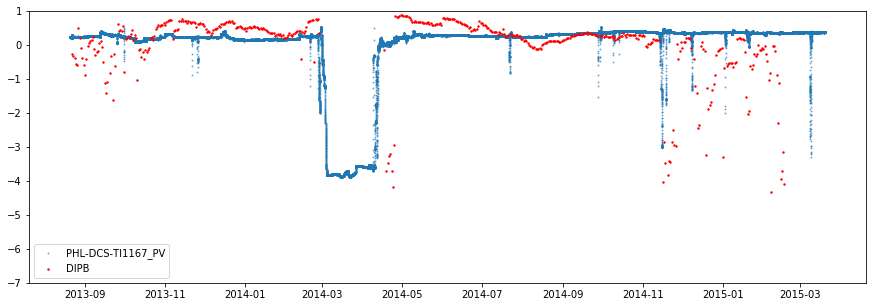

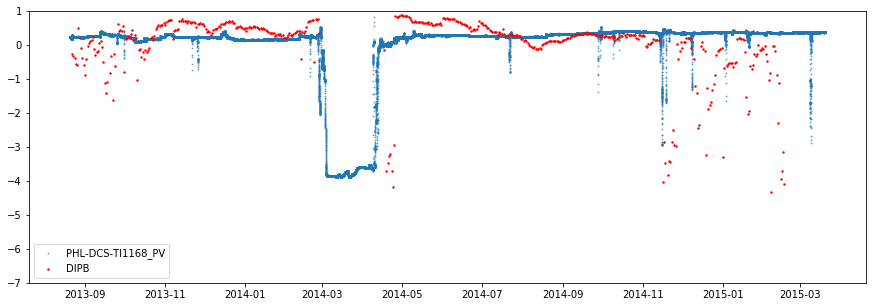

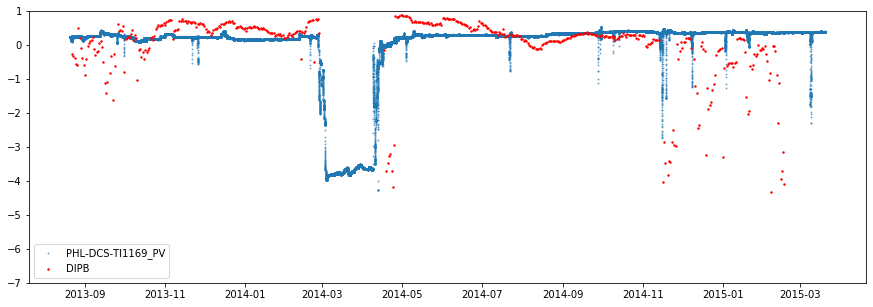

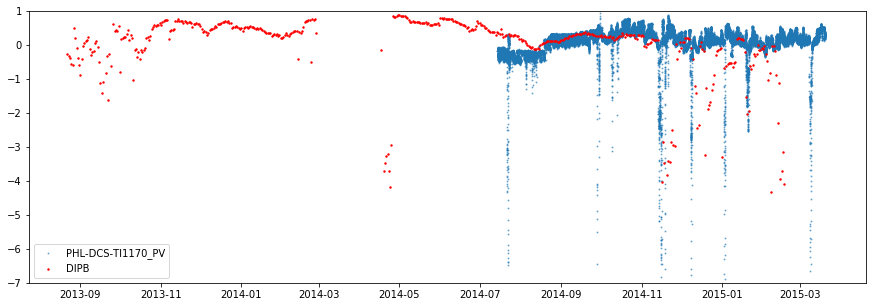

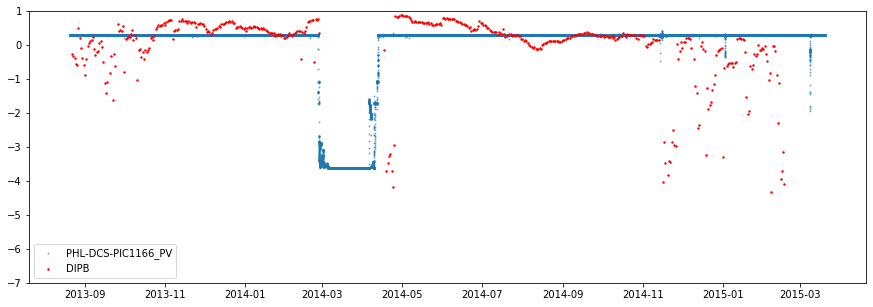

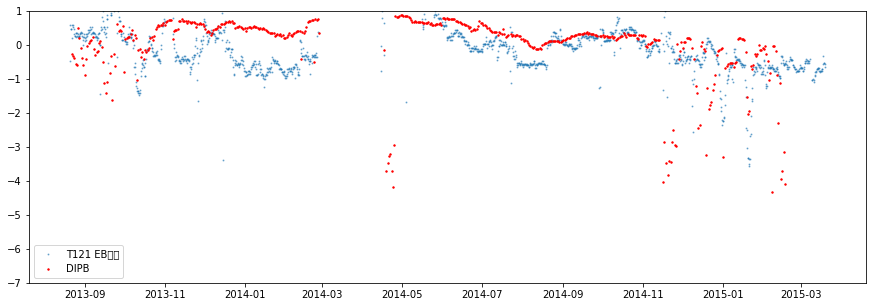

In [146]:
for x in features:
  fig = plt.figure(figsize=(15,5))
  plt.scatter(data.index,data[x],label=x,s=1,alpha=0.5)
  plt.scatter(data.index,data['DIPB轉化率'],label='DIPB',color='red',s=2)
  plt.ylim(-7,1)
  plt.legend(loc=3)
  plt.show()

# 視覺化探索數據

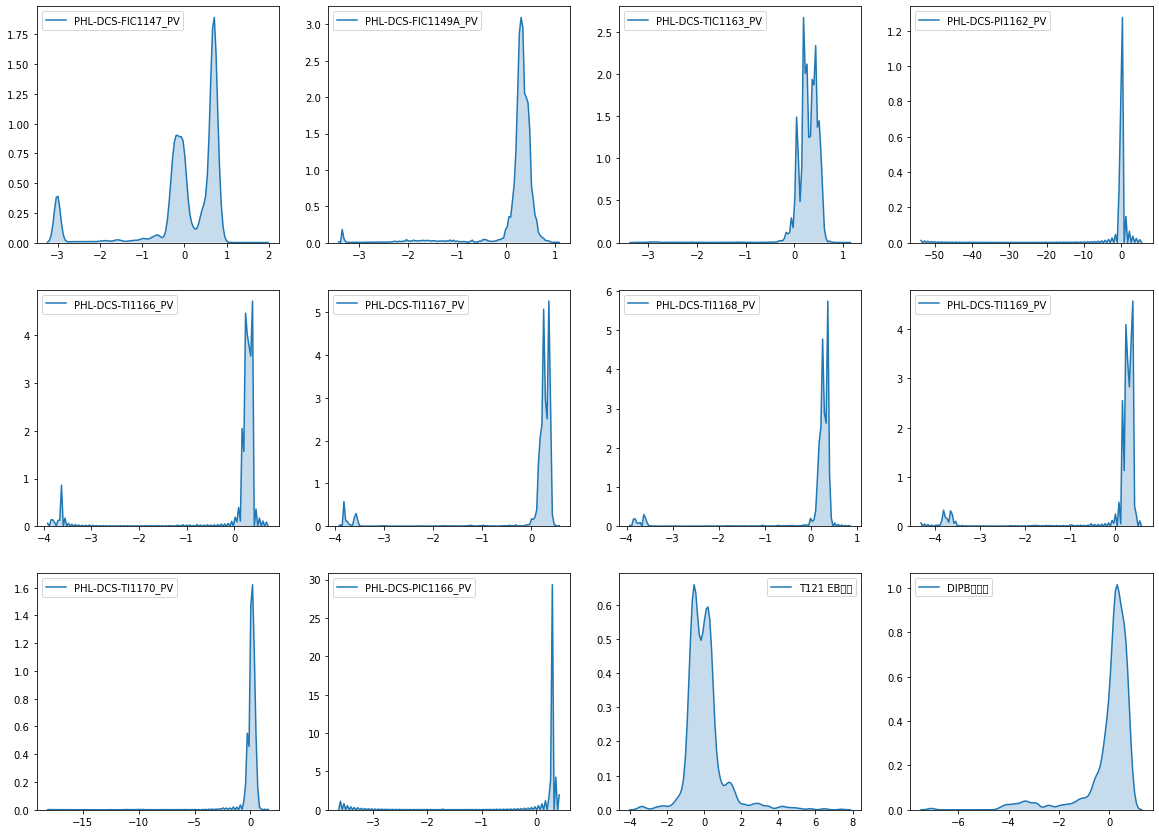

In [147]:
fig = plt.figure(figsize=(20,20))
for i,col in enumerate(data.columns):
  plt.subplot(4,4,i+1)
  sns.kdeplot(data[col],shade=True)
plt.show()

# scatter

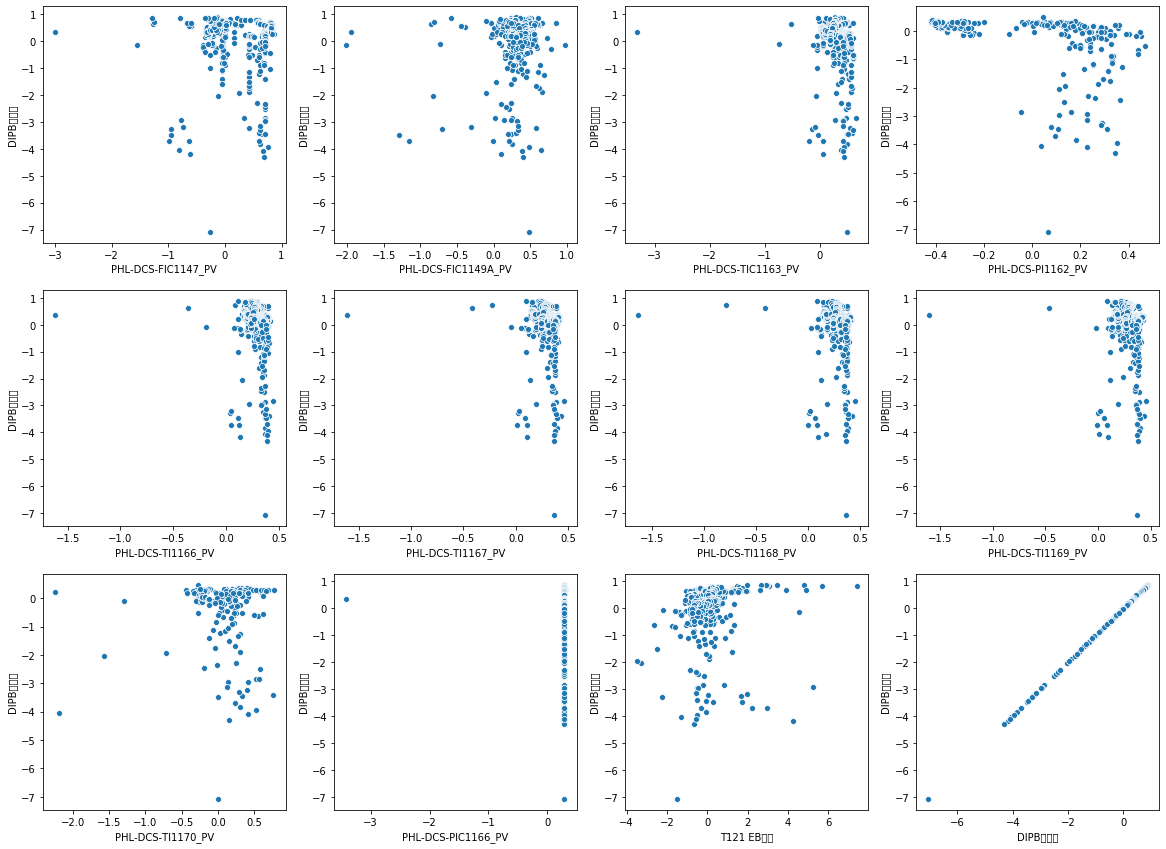

In [148]:
import seaborn as sns
fig = plt.figure(figsize=(20,20))
for i,col in enumerate(data.columns):
  plt.subplot(4,4,i+1)
  sns.scatterplot(x=col,y=y_name,data=data)
plt.show()

# corr

In [149]:
print('經過絕對值轉換')
abs(data.corr()).style.background_gradient(axis=1)

經過絕對值轉換


,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率
PHL-DCS-FIC1147_PV,1,0.884923,0.89913,0.304174,0.849823,0.847297,0.841579,0.862173,0.73121,0.844226,0.23428,0.0443793
PHL-DCS-FIC1149A_PV,0.884923,1,0.934985,0.365651,0.877757,0.868036,0.859819,0.882931,0.683053,0.880731,0.0201724,0.121691
PHL-DCS-TIC1163_PV,0.89913,0.934985,1,0.350941,0.94357,0.932389,0.923426,0.939352,0.604921,0.947079,0.0629258,0.156108
PHL-DCS-PI1162_PV,0.304174,0.365651,0.350941,1,0.309391,0.262835,0.297407,0.274725,0.325315,0.962897,0.261149,0.321703
PHL-DCS-TI1166_PV,0.849823,0.877757,0.94357,0.309391,1,0.991727,0.984078,0.978121,0.648831,0.940254,0.0662891,0.128274
PHL-DCS-TI1167_PV,0.847297,0.868036,0.932389,0.262835,0.991727,1,0.994928,0.986913,0.689236,0.943591,0.082717,0.13459
PHL-DCS-TI1168_PV,0.841579,0.859819,0.923426,0.297407,0.984078,0.994928,1,0.991156,0.789451,0.941671,0.0921779,0.116291
PHL-DCS-TI1169_PV,0.862173,0.882931,0.939352,0.274725,0.978121,0.986913,0.991156,1,0.916927,0.959771,0.100037,0.096656
PHL-DCS-TI1170_PV,0.73121,0.683053,0.604921,0.325315,0.648831,0.689236,0.789451,0.916927,1,0.350758,0.291141,0.053617
PHL-DCS-PIC1166_PV,0.844226,0.880731,0.947079,0.962897,0.940254,0.943591,0.941671,0.959771,0.350758,1,0.0576365,0.0165576


# spearman

In [150]:
from scipy import stats
df = data
cols = df.columns.tolist()
corr,p_value = stats.spearmanr(df.dropna())
corr = pd.DataFrame(corr,index=cols,columns=cols)
corr = abs(corr).sort_values(by='DIPB轉化率',ascending=False)
idx = corr.index
corr.loc[idx,idx].style.background_gradient()

,DIPB轉化率,T121 EB含量,PHL-DCS-PI1162_PV,PHL-DCS-FIC1147_PV,PHL-DCS-TI1166_PV,PHL-DCS-TIC1163_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV
DIPB轉化率,1,0.593109,0.554921,0.379564,0.225534,0.225297,0.180915,0.152491,0.120173,0.119331,0.0993438,0.0727952
T121 EB含量,0.593109,1,0.403137,0.25905,0.0725723,0.156058,0.295391,0.505087,0.123734,0.249727,0.272292,0.295817
PHL-DCS-PI1162_PV,0.554921,0.403137,1,0.195691,0.546123,0.56052,0.0968422,0.00920915,0.175301,0.468712,0.463368,0.42084
PHL-DCS-FIC1147_PV,0.379564,0.25905,0.195691,1,0.154793,0.185065,0.0982364,0.0156475,0.0243327,0.200474,0.141573,0.116973
PHL-DCS-TI1166_PV,0.225534,0.0725723,0.546123,0.154793,1,0.742926,0.268558,0.566524,0.0115388,0.887805,0.881365,0.856844
PHL-DCS-TIC1163_PV,0.225297,0.156058,0.56052,0.185065,0.742926,1,0.359348,0.542147,0.0221614,0.819481,0.817231,0.797799
PHL-DCS-FIC1149A_PV,0.180915,0.295391,0.0968422,0.0982364,0.268558,0.359348,1,0.282387,0.0214473,0.264655,0.267192,0.275963
PHL-DCS-TI1170_PV,0.152491,0.505087,0.00920915,0.0156475,0.566524,0.542147,0.282387,1,0.0198465,0.664601,0.706885,0.756542
PHL-DCS-PIC1166_PV,0.120173,0.123734,0.175301,0.0243327,0.0115388,0.0221614,0.0214473,0.0198465,1,0.0163939,0.0135978,0.021846
PHL-DCS-TI1167_PV,0.119331,0.249727,0.468712,0.200474,0.887805,0.819481,0.264655,0.664601,0.0163939,1,0.978234,0.95853


# kdeplot

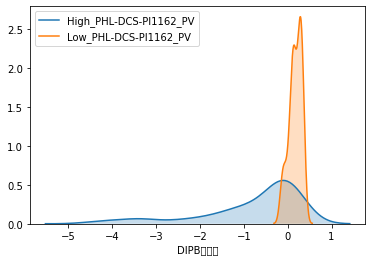

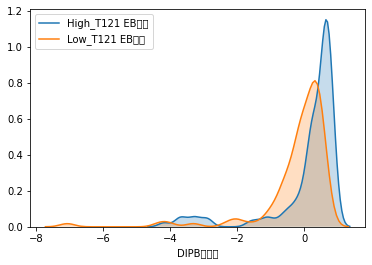

In [151]:
for by_col in ['PHL-DCS-PI1162_PV','T121 EB含量']:
  c1 = data.loc[ data[by_col] > data[by_col].quantile(0.75) ,y_name]
  c2 = data.loc[ data[by_col] < data[by_col].quantile(0.25) ,y_name]
  plt.xlabel(y_name)
  sns.kdeplot(c1,label='High_'+by_col,shade=True)
  sns.kdeplot(c2,label='Low_'+by_col,shade=True)
  plt.show()

# prepare data for modeling

In [0]:
data = data.rename(columns={'T121 EB含量':'EB',
                            'DIPB轉化率':'DIPB'})

In [0]:
features = ['PHL-DCS-PI1162_PV','EB']
y_name = 'DIPB'

In [154]:
data[:] = scaler.inverse_transform(data[:])
data.describe()

,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,EB,DIPB
count,82957.000000,82957.000000,82957.000000,35751.000000,82957.000000,82957.000000,82957.000000,82957.000000,35752.000000,82957.000000,1558.000000,488.000000
mean,33.273954,22.735229,165.897777,14.407912,157.729230,157.845917,157.635257,156.099047,164.570401,11.393804,97.086008,60.076976
std,11.021101,6.740962,16.821397,0.130853,36.050573,36.135804,36.093345,36.585011,6.079057,3.142741,25.089365,14.727260
min,0.030600,0.000000,110.036342,7.405875,17.491865,17.297280,17.147366,0.000000,54.792718,0.000000,8.000000,-44.018765
25%,31.115886,24.172923,168.804199,14.379764,165.680884,165.377793,165.010240,163.469034,164.389057,12.297432,83.000000,59.095579
50%,35.164770,24.802710,170.478271,14.423795,167.543546,167.692276,167.440315,166.494383,165.372856,12.299720,94.000000,64.216984
75%,40.985432,25.495527,173.020995,14.440059,170.294464,170.670847,170.388229,169.366086,166.366321,12.301856,105.000000,67.893455
max,52.727678,29.718892,184.354069,15.104876,182.300190,177.281587,187.304338,176.016768,173.643521,12.729884,283.000000,72.991308


In [155]:
print(data.shape)
data = data.dropna(subset=features+[y_name])
print(data.shape)

(83028, 12)
(212, 12)


In [156]:
X = data[features]
y = data[y_name]
print(X.shape,y.shape)

(212, 2) (212,)


In [157]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(169, 2) (169,)
(43, 2) (43,)


# modeling

In [0]:
def metric(yt,yp,name):
  res = {
      'R2':r2_score(yt,yp),
      'MAE':mean_absolute_error(yt,yp)}
  return pd.DataFrame(res,index=[name])

# modeling

In [174]:
model = XGBRegressor(objective='reg:squarederror',n_estimators=1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
metric(y_test,y_pred,'test')

,R2,MAE
test,-7.280107,47.820869


In [177]:
#當分類問題
y_train_class = (y_train>y_train.median()).astype(int).values
y_test_class = (y_test>y_train.median()).astype(int).values
model = XGBClassifier(n_estimators=1)
model.fit(X_train,y_train_class)
model.score(X_test,y_test_class)

0.8372093023255814

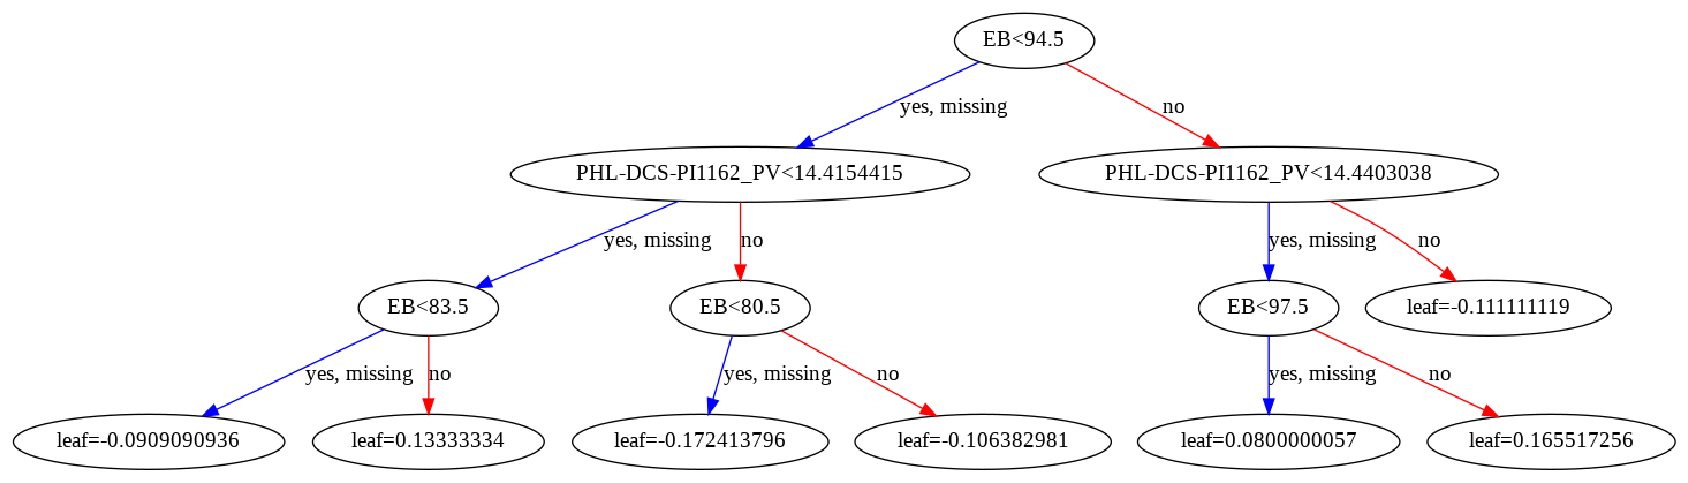

In [178]:
fig, ax = plt.subplots(figsize=(30, 30))
xgboost.plot_tree(model,num_trees=0, ax=ax)
plt.show()